# Incremental Evaluation

## 1 - Load the data

In [1]:
# Imports

import json
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from compare import *

# Set this to the path where the data is 
DATA_ROOT = 'C:\openmic-2018\openmic-2018'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')


In [2]:
# Loading the data
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)

# Make direct variable names for everything
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']


In [3]:
# Map class indices to names
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

In [4]:
class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

## 2 - Load the splits
### Creating splits for train, test, and the unlabeled data.
###### Adapted from the original OpenMIC notebook

In [5]:
# Split the data into train, test, and unlabeled sets
# Use squeeze=True here to return a single array for each, rather than a full DataFrame

split_train = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_train.csv'), 
                          header=None).squeeze("columns")
split_test = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_test.csv'), 
                         header=None).squeeze("columns")

# Create partition CSV for unlabeled
split_unlabeled = pd.read_csv(os.path.join(DATA_ROOT, 'partitions/split01_unlabeled.csv'), 
                         header=None).squeeze("columns")

In [6]:
# The breakdown of the data is roughly 50% training, 25% test, 25% unlabeled
# The percentage breakdowns can be adjusted by adjusting the partitions csv's above 
print('# Train: {},  # Test: {}, # Unlabeled: {}'.format(len(split_train), len(split_test), len(split_unlabeled)))

# Train: 9993,  # Test: 5085, # Unlabeled: 4922


In [7]:
train_set = set(split_train)
test_set = set(split_test)
unlabeled_set = set(split_unlabeled)

In [8]:
# Split the data into arrays

idx_train, idx_test, idx_unlabeled = [], [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    elif n in unlabeled_set:
        idx_unlabeled.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))

# Cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)
idx_unlabeled = np.asarray(idx_unlabeled)

In [9]:
# Finally, we use the split indices to partition the features, labels, and masks
X_train = X[idx_train]
X_test = X[idx_test]
X_unlabeled = X[idx_unlabeled]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]
Y_true_unlabeled = Y_true[idx_unlabeled]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]
Y_mask_unlabeled = Y_mask[idx_unlabeled]

In [10]:
# Validate shapes of slices
print(X_train.shape)
print(X_test.shape)
print(X_unlabeled.shape)

(9993, 10, 128)
(5085, 10, 128)
(4922, 10, 128)


## 3 - Fit the models

In [11]:
models = dict()

for instrument in class_map:

    # get column num from instrument name
    inst_num = class_map[instrument]

    rfc = trainModel("rfc",inst_num, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test)[0]
    knn = trainModel("knn",inst_num, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test)[0]
    
    # Store the classifier in our dictionary
    models[instrument] = [rfc, knn]

## 4 - Algorithmic Disagreement

#### In the algorithimc disagreement process, two models evaluate the same piece of data and their evaluations are compared. If they disagree on their evaluation, that track is deemed to be a priority for annotation.
##### Let's start with an example

In [12]:
# We need soundfile to load audio data
import soundfile as sf

# For audio playback
from IPython.display import Audio

In [13]:
# Run algorithmic disagreement process

# Populate skipIndices with empty arrays to be filled
# skipIndices = {}
# for i in class_map:
#     skipIndices[i] = []


# uncertaintyScores, allPredictions = compare(X_unlabeled, models, skipIndices=skipIndices)

In [14]:
# uncertaintyScores["voice"]

In [15]:
# list(uncertaintyScores["voice"].items())[:5]

In [16]:
# Get ID of the most uncertain track for voice
# highest_idx = list(uncertaintyScores.get("voice").items())[0][0]
# trackID = split_unlabeled[highest_idx]

In [17]:
# And the most uncertain track is...
# trackID

Let's hear what this difficult-to-label track sounds like!

In [18]:
# Replace below .ogg file with trackID
# audio, rate = sf.read(os.path.join(DATA_ROOT, 'audio/000/000493_42240.ogg'))

In [19]:
# Let's listen to the example
# Audio(data=audio.T, rate=rate)

### 5 - Incremental Evaluation -- Simulate the Annotation Process

In [20]:
# First, train a model on the fully annotated dataset. This is what we will be measuring efficiency against. 
combined_models = dict()

for instrument in class_map:

    # get column num from instrument name
    inst_num = class_map[instrument]

    rfc, X_test_inst_sklearn, Y_true_test_inst = trainModel("rfc",inst_num, X_train, X_test, Y_true_train, \
                                                                                  Y_true_test, Y_mask_train, Y_mask_test)
    combined_models[instrument] = rfc


In [21]:
# Constants
NUM_TO_LABEL = 400  # Batch size
NUM_RANDOM = 10      # Number of random tracks to include 
EPOCHS = 10        # Number of times to annotate

# Set Up
skipIndices = {}
accuracies_over_time = {}
ctrl_accuracies = {}
for i in class_map:
    skipIndices[i] = []
    accuracies_over_time[i] = []
    ctrl_accuracies[i] = []

# MAIN LOOP
for i in range(EPOCHS):

    # get instrument predictions
    sorted_trx, allInstProbs = compare(X_unlabeled, models, skipIndices=skipIndices)

    for instr in sorted_trx:    
        X_labeled = []           # Track IDs for labeled tracks
        Y_true_labeled = []      # True values for labeled tracks
        Y_mask_labeled = []      # Boolean values for labeled tracks

        ###########################################################################
        # SELECT TRACKS FOR ANNOTATION

        # Retrieve the top tracks for annotation
        track_indices = list(sorted_trx[instr].items())[:NUM_TO_LABEL]
        track_indices = [i[0] for i in track_indices]   # isolates the indices

        # add random tracks to be annotated to avoid false positives
        track_indices = addRandomTracks(NUM_RANDOM, len(sorted_trx[instr]), track_indices)

        # add track IDs to the labeled list
        for trk in track_indices:
            X_labeled.append(X_unlabeled[trk])
            Y_true_labeled.append(Y_true_unlabeled[trk])
            Y_mask_labeled.append(Y_mask_unlabeled[trk])

        # Update indices to skip here
        skipIndices[instr] = np.append(skipIndices[instr], track_indices)


        
        ###########################################################################
        # TRAIN MODEL ON PARTIALLY ANNOTATED DATASET
        
        inst_num = class_map[instr]
        model, X_test_inst_sklearn, Y_true_test_inst = trainModel(modelType="rfc",inst_num=inst_num, X_train=X_train, X_test=X_test, \
                X_labeled=X_labeled, Y_true_train=Y_true_train, Y_true_test=Y_true_test, Y_true_labeled=np.array(Y_true_labeled), \
                Y_mask_train=Y_mask_train, Y_mask_test=Y_mask_test)


        ###########################################################################
        # COMPARE ACCURACY WITH FULLY ANNOTATED MODEL

        # Graph the accuracy results
        control_model = combined_models[instr]

        Y_pred_test_ctrl = control_model.predict(X_test_inst_sklearn)
        Y_pred_test_rfc = model.predict(X_test_inst_sklearn)

        acc = classification_report(Y_true_test_inst, Y_pred_test_rfc, output_dict=True)["accuracy"]  
        ctrl_acc = classification_report(Y_true_test_inst, Y_pred_test_ctrl, output_dict=True)["accuracy"]  

        print(i,":", instr,"Control accuracy:", ctrl_acc, "\tNewly trained accuracy:", acc)

        accuracies_over_time[instr].append(acc)
        ctrl_accuracies[instr].append(ctrl_acc)


0 : accordion Control accuracy: 0.8271375464684015 	Newly trained accuracy: 0.7509293680297398
0 : banjo Control accuracy: 0.7845188284518828 	Newly trained accuracy: 0.6527196652719666
0 : bass Control accuracy: 0.8336933045356372 	Newly trained accuracy: 0.7775377969762419
0 : cello Control accuracy: 0.7917525773195876 	Newly trained accuracy: 0.7484536082474227
0 : clarinet Control accuracy: 0.790625 	Newly trained accuracy: 0.709375
0 : cymbals Control accuracy: 0.9426605504587156 	Newly trained accuracy: 0.8761467889908257
0 : drums Control accuracy: 0.9080188679245284 	Newly trained accuracy: 0.8726415094339622
0 : flute Control accuracy: 0.7508896797153025 	Newly trained accuracy: 0.6743772241992882
0 : guitar Control accuracy: 0.9701834862385321 	Newly trained accuracy: 0.8509174311926605
0 : mallet_percussion Control accuracy: 0.7719665271966527 	Newly trained accuracy: 0.7301255230125523
0 : mandolin Control accuracy: 0.7623604465709729 	Newly trained accuracy: 0.668261562998

# Graph the results

In [22]:
import matplotlib.pyplot as plt

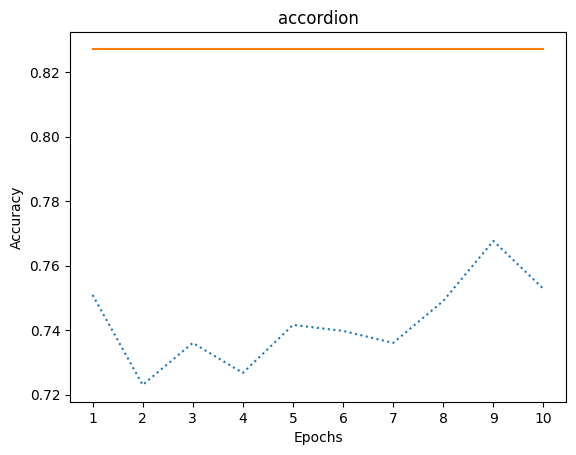

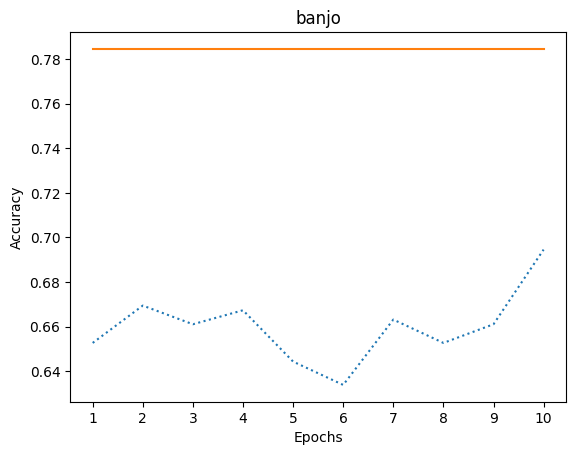

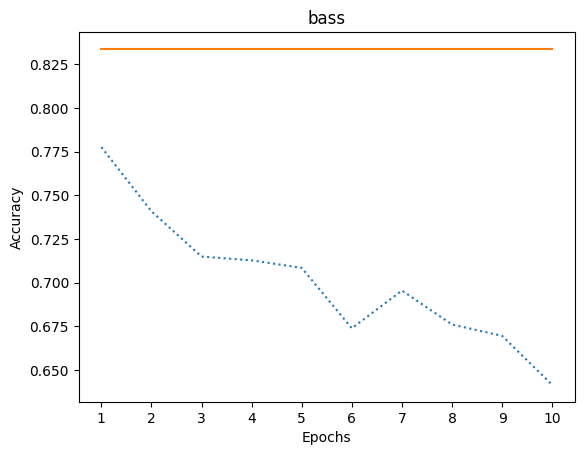

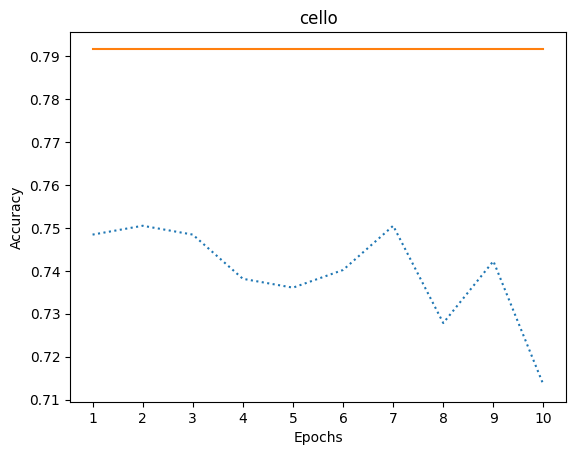

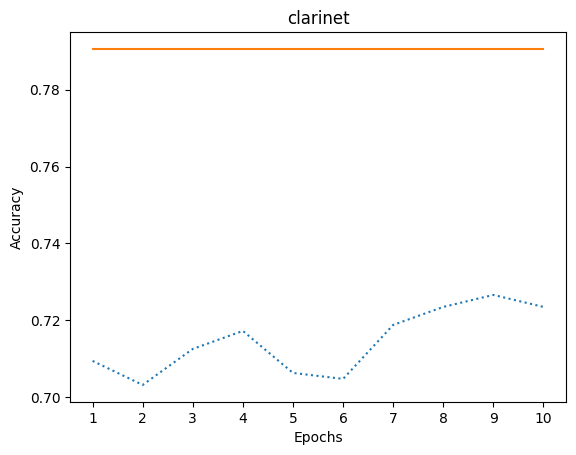

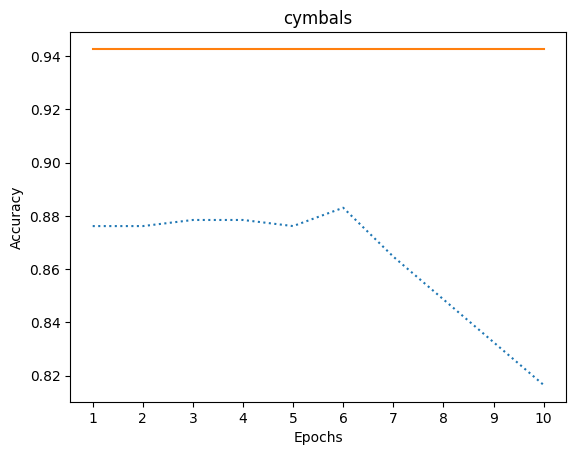

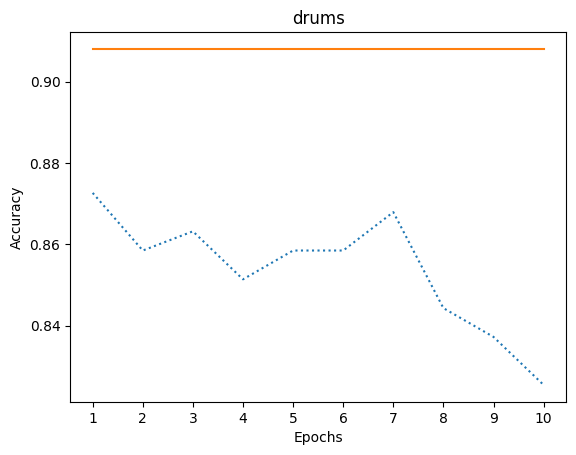

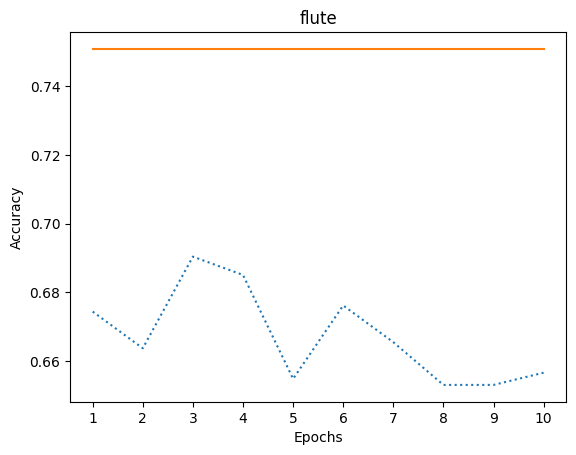

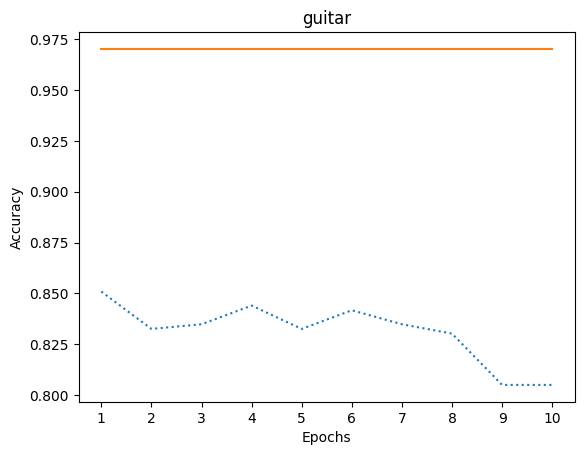

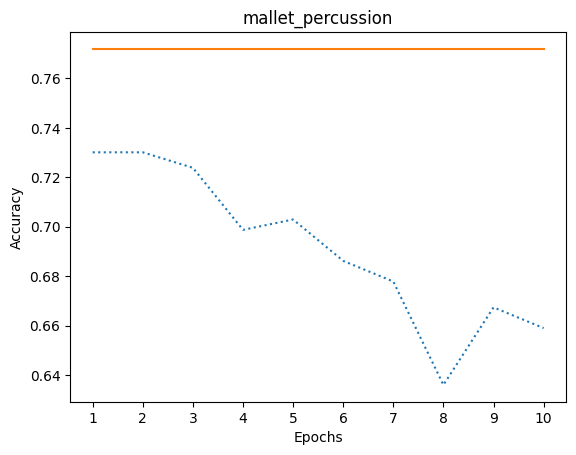

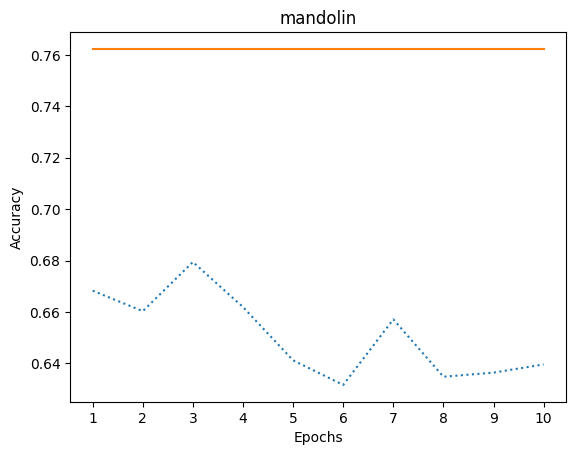

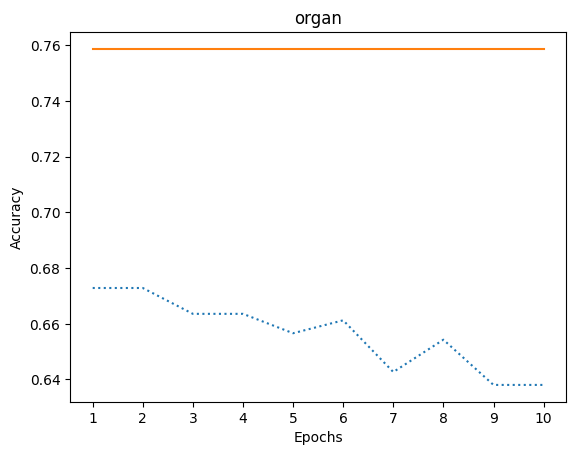

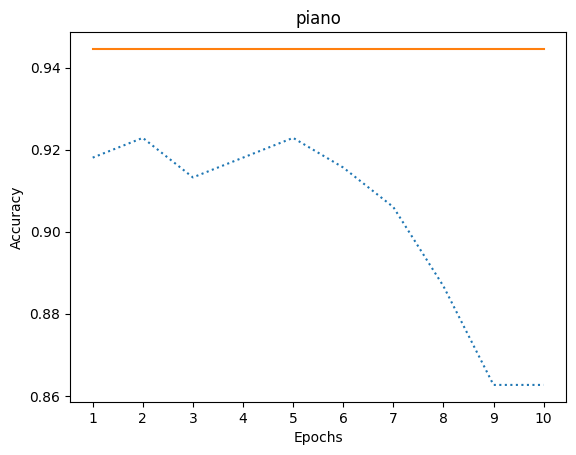

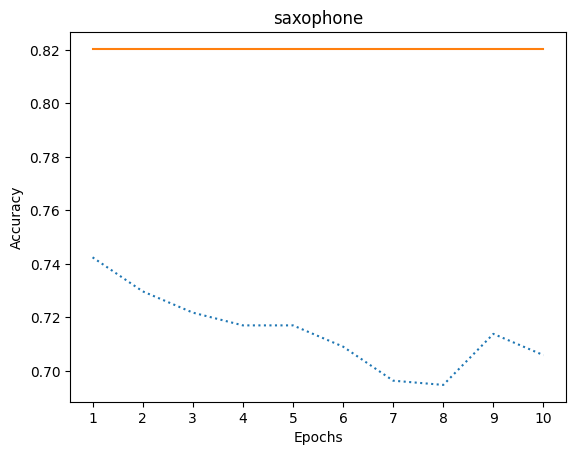

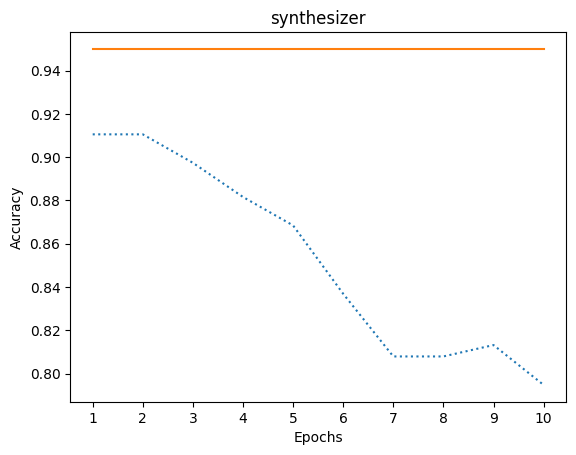

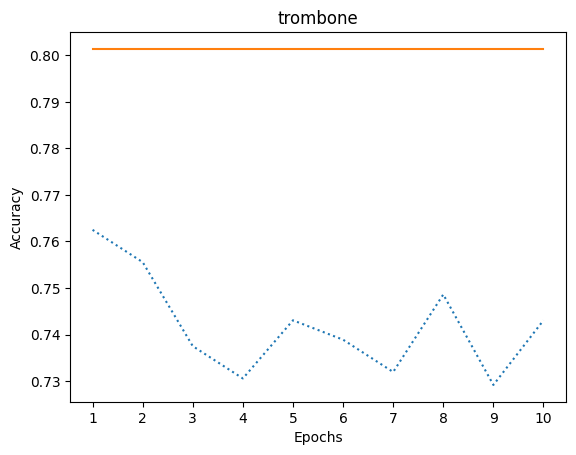

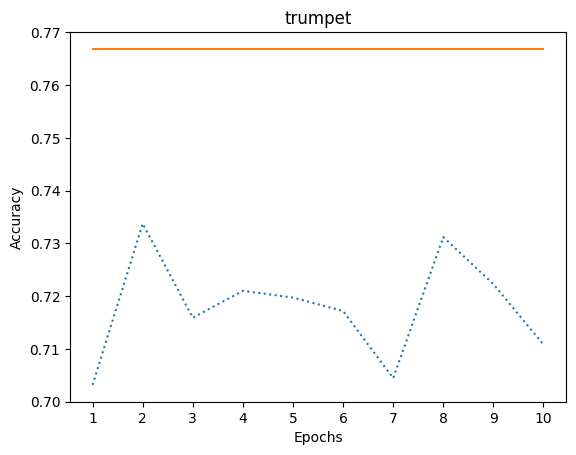

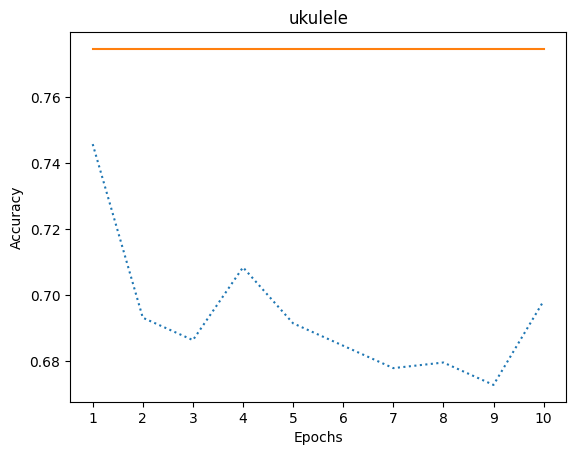

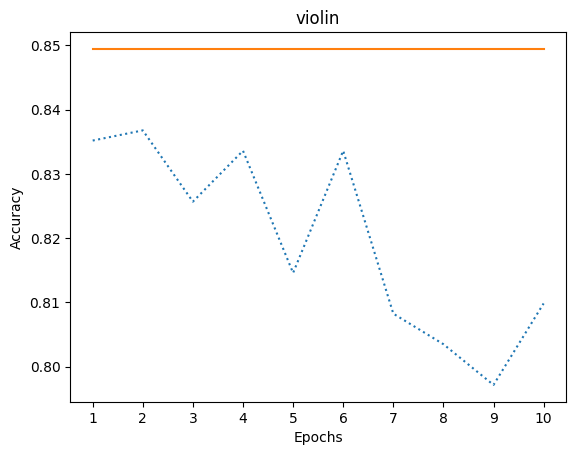

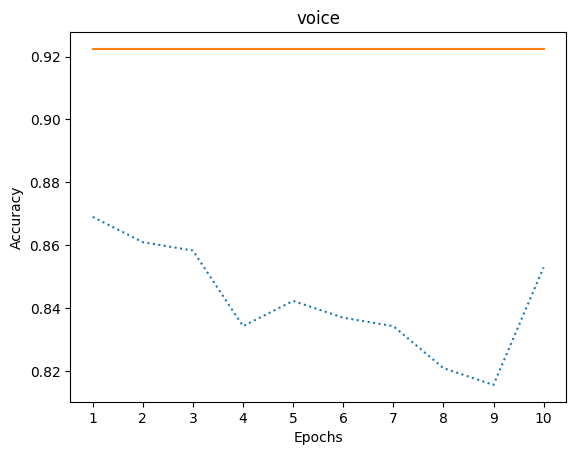

In [23]:
for i in class_map:
    plt.plot(accuracies_over_time[i], linestyle='dotted')
    plt.plot(ctrl_accuracies[i])
    plt.xlabel("Epochs")
    plt.xticks(np.arange(len(accuracies_over_time[i])), np.arange(1, len(accuracies_over_time[i])+1))
    plt.ylabel("Accuracy")
    plt.title(i)
    plt.show()

To Do
* Error handling
* Tweak KNN # of neighbors
* Update README